In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms 
from livelossplot import PlotLosses

%matplotlib inline
import time

In [23]:
# Hyperparameters
num_epoches = 20
#num_classes = 10
batch_size = 100
learning_rate = 0.0001

# transforms to apply to the data
#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST('fashion_Mnist_data/', train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.FashionMNIST('fashion_Mnist_data/', train=False, transform=trans, download=True)

# load dataset into data_loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {
    "train": train_loader,
    "test": test_loader
}

## Task 1
The structure of CNN:
    - Softmax(10)
    - FC(256)
    - Conv(128) filter size: 3x3, stride: 2
    - Conv(64) filter size: 3x3, stride: 2
    - Conv(32) filter size: 3x3, stride: 2
### Task 1 - CNN Model Definition

In [24]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)  # 28x28
        self.layer2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 14x14
        self.layer3 = nn.Conv2d(64, 128, 3, stride=2)      # 7x7
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3*3*128,256)       # 3x3
        self.fc2 = nn.Linear(256,10)

    # data flows through these layers
    def forward(self, x):
        c = F.relu(self.layer1(x))
        c = F.relu(self.layer2(c))
        c = F.relu(self.layer3(c))
        c = c.reshape(c.size(0), -1)
        c = self.drop_out(c)
        c = self.fc1(c)
        c = self.fc2(c)
        return c
    

### Task 1 - End of CNN Model Definition

In [25]:
CNN = CNNModel()

In [31]:
# https://drive.google.com/file/d/1qUNEva1_AqC1uoFKGE5HG2uWW8Bm5j7t/view?usp=sharing
fid = '1qUNEva1_AqC1uoFKGE5HG2uWW8Bm5j7t'

import wget
def download(fid, fn):
    durl = 'https://drive.google.com/' + 'uc?export=download&id=' + fid
    print('downloading from', durl)
    wget.download(durl, fn)
    
download(fid, 't1w.pt')
CNN.load_state_dict(torch.load('t1w.pt'))

downloading from https://drive.google.com/uc?export=download&id=1qUNEva1_AqC1uoFKGE5HG2uWW8Bm5j7t


<All keys matched successfully>

### Task 1 - Training the CNN model

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def run_model(model, criterion, optimizer, num_epoches):
    liveloss = PlotLosses()
    model = model.to(device)

    for epoch in range(num_epoches):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()

In [28]:
CNN = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), learning_rate)

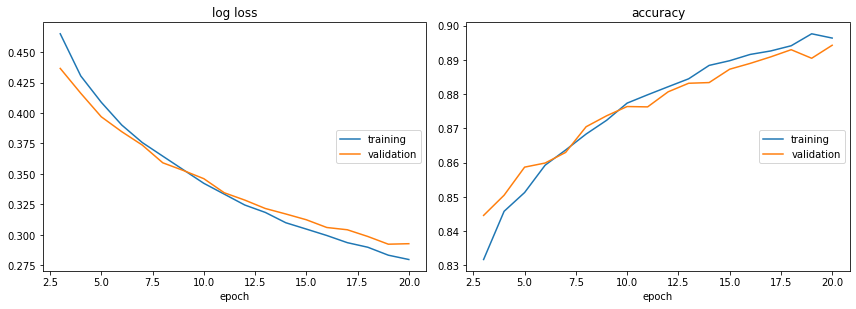

log loss:
training   (min:    0.280, max:    0.820, cur:    0.280)
validation (min:    0.292, max:    0.544, cur:    0.293)

accuracy:
training   (min:    0.714, max:    0.898, cur:    0.896)
validation (min:    0.800, max:    0.894, cur:    0.894)


In [29]:
# Run the train and test dataset together
run_model(CNN, criterion, optimizer, num_epoches)

In [30]:
# Save the trained model
torch.save(CNN.state_dict(), 'CNN.pt')

## Task 2

In [138]:
# Hyperparameters
num_epochs = 20
latent_dims = 10     # latent vector dimension 
batch_size = 100
capacity = 32
variational_beta = 1
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

 ### Task 2 - VAE Model defination

In [103]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.encode_conv1 = nn.Conv2d(in_channels=1, out_channels=c,kernel_size=3, stride=1, padding=0) 
        self.encode_conv2 = nn.Conv2d(in_channels=c, out_channels=c*2,kernel_size=3, stride=1, padding=0) 
        self.encode_conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=3, stride=1,padding=0)
        self.encode_fc = nn.Linear(c*4*22*22, 256)     
        self.encode_mu = nn.Linear(in_features=256, out_features=latent_dims)
        self.encode_logvar = nn.Linear(in_features=256, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.encode_conv1(x))
        x = F.relu(self.encode_conv2(x))
        x = F.relu(self.encode_conv3(x))
        x = x.view(-1, capacity*4*22*22) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.encode_fc(x)
        x_mu = self.encode_mu(x)
        x_logvar = self.encode_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.decode_in = nn.Linear(in_features=latent_dims, out_features=256)
        self.decode_fc = nn.Linear(256, c*4*22*22)
        self.decode_conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=3, stride=1,padding=0)
        self.decode_conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c,kernel_size=3, stride=1,padding=0)
        self.decode_conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1,kernel_size=3, stride=1, padding=0)
            
    def forward(self, x):
        x = self.decode_in(x)
        x = self.decode_fc(x)
        
        # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = x.view(-1, capacity*4, 22,22) 
        x = F.relu(self.decode_conv3(x))
        x = F.relu(self.decode_conv2(x))
        # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        x = torch.sigmoid(self.decode_conv1(x)) 
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 31974805


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


### Task 2 - Train the VAE model

In [142]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_loader:
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))   

Training ...
Epoch [1 / 20] average reconstruction error: -1472345.427917
Epoch [2 / 20] average reconstruction error: -1408105.161875
Epoch [3 / 20] average reconstruction error: -1380854.050625
Epoch [4 / 20] average reconstruction error: -1366116.199583
Epoch [5 / 20] average reconstruction error: -1355055.010625
Epoch [6 / 20] average reconstruction error: -1348335.303333
Epoch [7 / 20] average reconstruction error: -1342956.863333
Epoch [8 / 20] average reconstruction error: -1338894.908750
Epoch [9 / 20] average reconstruction error: -1335126.784792
Epoch [10 / 20] average reconstruction error: -1331818.765625
Epoch [11 / 20] average reconstruction error: -1328846.583333
Epoch [12 / 20] average reconstruction error: -1326188.236875
Epoch [13 / 20] average reconstruction error: -1323971.219583
Epoch [14 / 20] average reconstruction error: -1321859.621875
Epoch [15 / 20] average reconstruction error: -1319936.467708
Epoch [16 / 20] average reconstruction error: -1318216.578750
Epoc

In [143]:
# Save the trained VAE model
torch.save(vae.state_dict(), 'VAE.pt')

### Task 2 - (1) plot the distribution of the 2-norms of the encoding vectors

### Task 2 - Save and load the pre-trained VAE model

In [144]:
# Shared link with saved model
# https://drive.google.com/file/d/1_a-uKIiibdGiTCguLvjzEHggLRxZmUI2/view?usp=sharing

fid = '1_a-uKIiibdGiTCguLvjzEHggLRxZmUI2'

import wget
def download(fid, fn):
    durl = 'https://drive.google.com/' + 'uc?export=download&id=' + fid
    print('downloading from', durl)
    wget.download(durl, fn)
    
download(fid, 't2w.pt')
vae.load_state_dict(torch.load('t2w.pt'))

downloading from https://drive.google.com/uc?export=download&id=1zoqTVswNG_7kAjDmZ26thRNFBNHbIfkQ


UnpicklingError: invalid load key, '<'.

### Task 2 - (2) Visualize Reconstructions

Original images


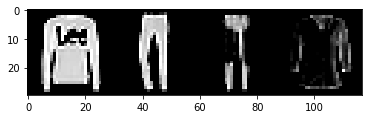

VAE reconstruction:


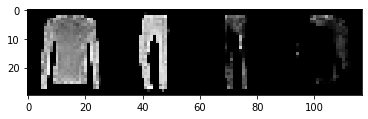

In [145]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:5], 5, 1).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:5],5,1))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

## Task 3

### Plot accuracy while train and test

In [107]:
def run_model(model, criterion, optimizer, num_epoches):
    liveloss = PlotLosses()
    model = model.to(device)

    for epoch in range(num_epoches):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #outputs = model(inputs)
                image_batch_recon, latent_mu, latent_logvar = model(image_batch)
                #loss = criterion(outputs, labels)
                loss = criterion(latent_mu, labels)
                
                # reconstruction error
                loss += vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
                latent_mu = F.softmax(latent_mu, dim=0)
                loss += criterion2(image_batch_recon.type(torch.float),image_batch.type(torch.float))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                #_, preds = torch.max(outputs, 1)
                _, preds = torch.max(latent_mu, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'test':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()

In [108]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
criterion2 = nn.KLDivLoss(reduction="sum")

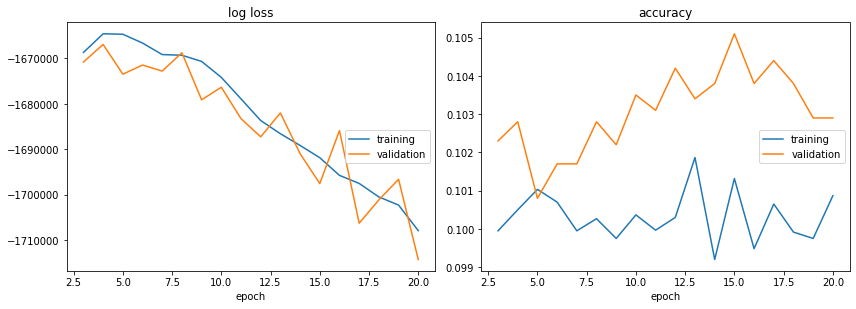

log loss:
training   (min: -1733611.625, max: -1664560.000, cur: -1707954.750)
validation (min: -1714321.375, max: -1666906.125, cur: -1714321.375)

accuracy:
training   (min:    0.099, max:    0.102, cur:    0.101)
validation (min:    0.101, max:    0.105, cur:    0.103)


In [109]:
run_model(vae, criterion, optimizer, num_epoches)

In [110]:
torch.save(vae.state_dict(), 'CNNVAE.pt')

### Save and load pre-trained combined Model

In [111]:
# The link to pre-trained model
# https://drive.google.com/file/d/1y9NExtt8o_44KDeikHerMEixlKxwfbzQ/view?usp=sharing

fid = '1y9NExtt8o_44KDeikHerMEixlKxwfbzQ'

import wget
def download(fid, fn):
    durl = 'https://drive.google.com/' + 'uc?export=download&id=' + fid
    print('downloading from', durl)
    wget.download(durl, fn)
    
download(fid, 't3w.pt')
vae.load_state_dict(torch.load('t3w.pt'))

downloading from https://drive.google.com/uc?export=download&id=1y9NExtt8o_44KDeikHerMEixlKxwfbzQ


UnpicklingError: invalid load key, '<'.

### Task 3 - Question 2